## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

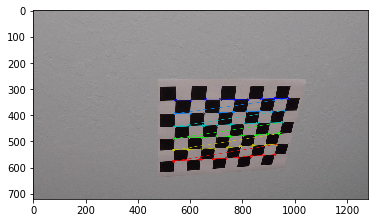

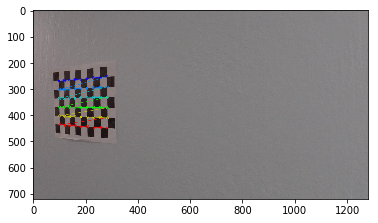

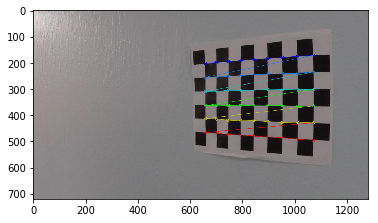

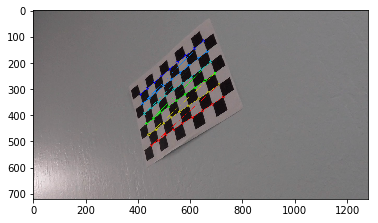

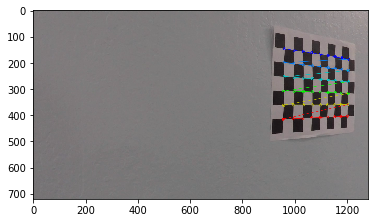

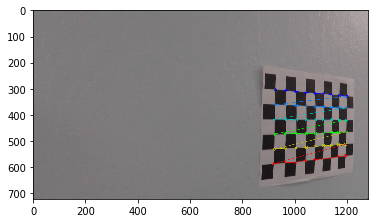

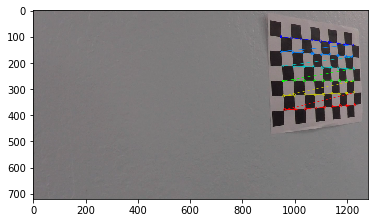

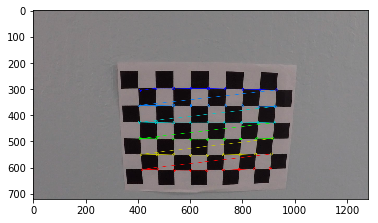

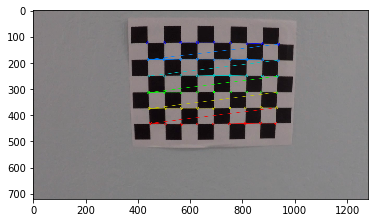

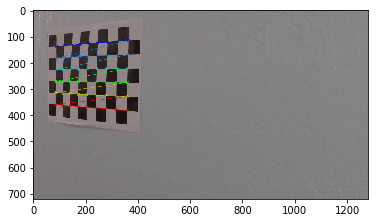

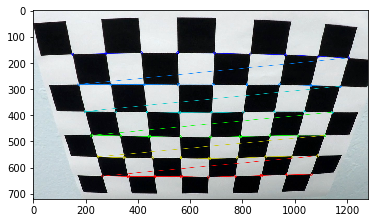

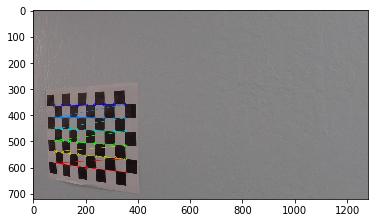

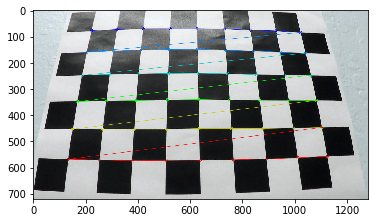

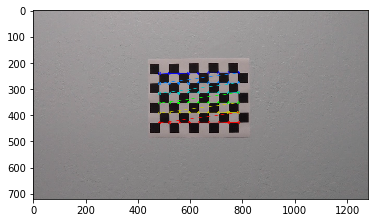

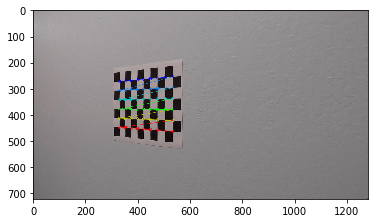

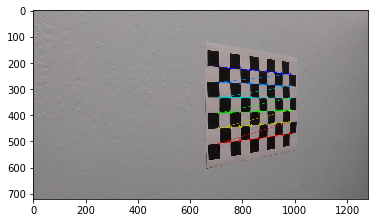

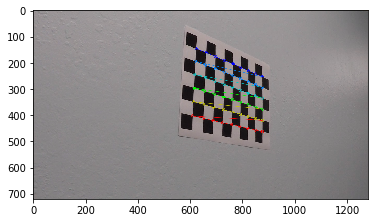

In [106]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pickle as pickle
%matplotlib qt
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        plt.imshow(img)
        plt.show()
        cv2.waitKey(500)
    cv2.destroyAllWindows()
    

## 2. Distortion Correction

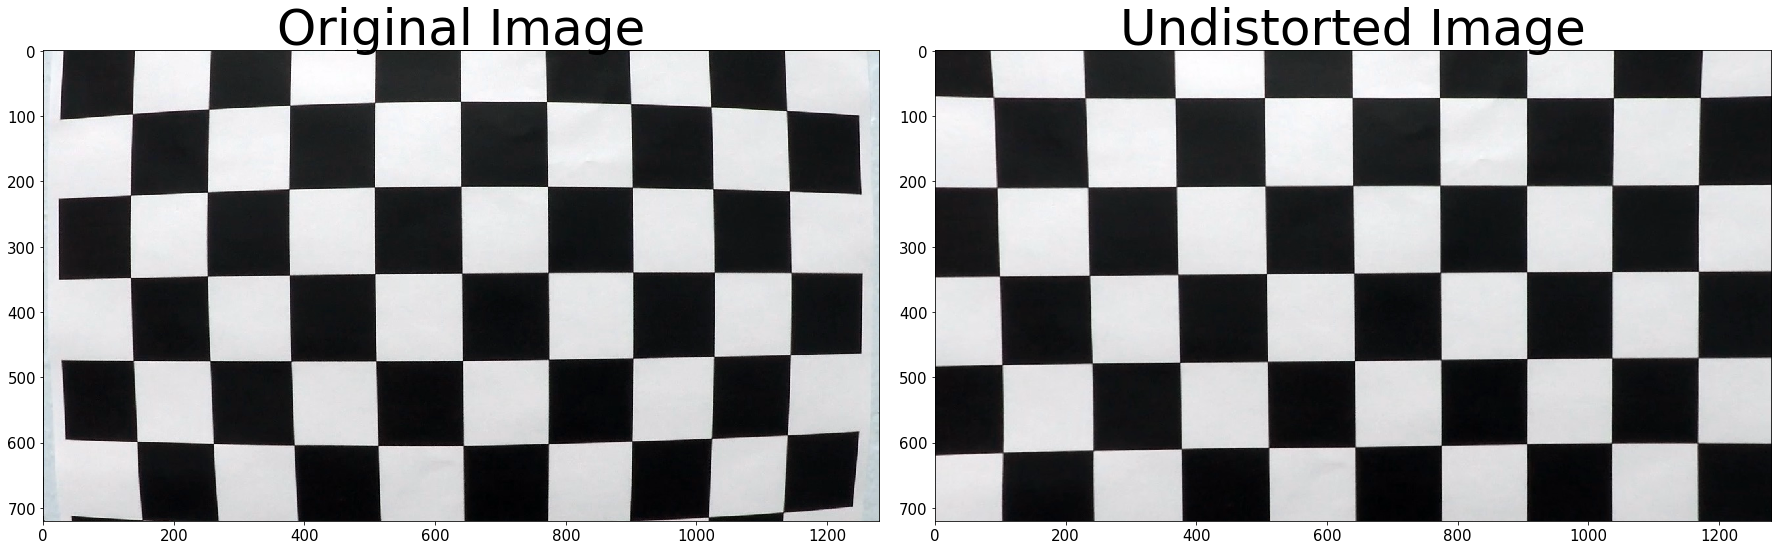

In [185]:
def undistort(img):
    img_size = (img.shape[1], img.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    #plt.imshow(dst)
    cv2.imwrite('camera_cal/calibration2_undist.jpg',dst)

    dist_pickle = {}
    dist_pickle["mtx"] = mtx
    dist_pickle["dist"] = dist
    pickle.dump(dist_pickle, open("../camera_cal/dist_pickle.p", "wb"));
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=50)
    ax2.imshow(dst)
    ax2.set_title('Undistorted Image', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    plt.savefig('../output_images/distortion_Correction.png', bbox_inches="tight")

    
img = cv2.imread('../camera_cal/calibration1.jpg')
undistort(img)


Checking on real images

In [110]:
import matplotlib as matplotlib

def plotResults(test_img, new_img):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
    f.tight_layout()
    matplotlib.rc('xtick', labelsize=15) 
    matplotlib.rc('ytick', labelsize=15)
    ax1.imshow(test_img)
    ax1.set_title('Original Image:', fontsize=15)

    ax2.imshow(new_img, cmap='gray')
    ax2.set_title('Modified Image', fontsize=15)

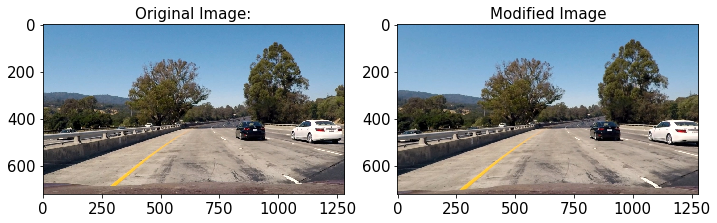

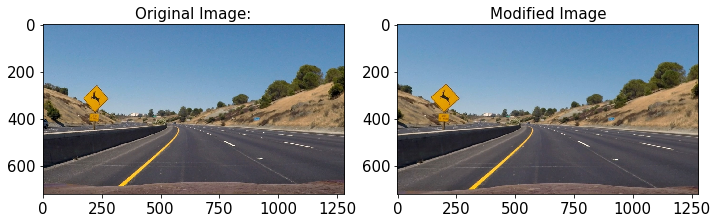

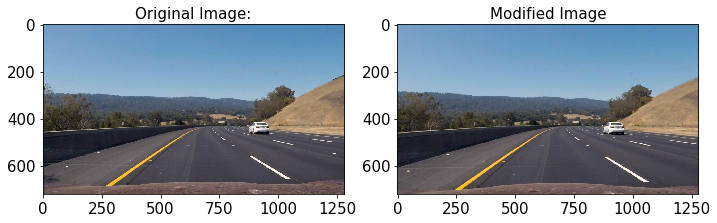

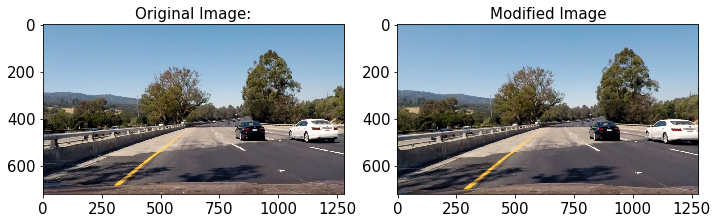

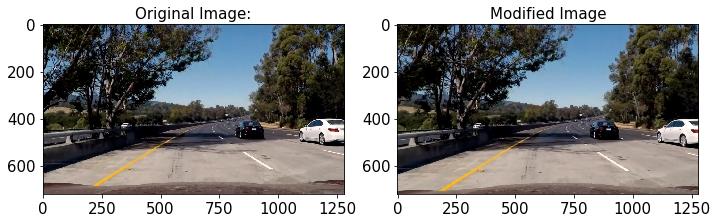

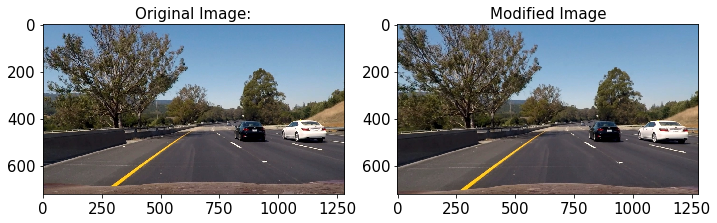

In [117]:
images = glob.glob('../test_images/test*.jpg')
dist_pickle = pickle.load(open("../camera_cal/dist_pickle.p", "rb" ))
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

for image in images:
    img = cv2.imread(image)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    mtx = dist_pickle['mtx']
    dist = dist_pickle['dist']
    undistoredImg = cv2.undistort(img, mtx, dist, None, mtx)
    plotResults(img, undistoredImg)
    plt.savefig('../output_images/undistorted.png', bbox_inches="tight")
    plt.show()

## 3. Color Transform



### Visualizing Sobel

#### Sobel X

In [208]:
def sobel_x(img, threshold_MIN=15, threshold_MAX=255):
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = 3)
        abs_sobel = np.absolute(sobel)
        scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
        binary_output = np.zeros_like(scaled_sobel)
        binary_output[(scaled_sobel >= threshold_MIN) & (scaled_sobel <= threshold_MAX)] = 1
        plt.savefig('../output_images/sobel_x.png', bbox_inches="tight")
        #plotResults(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), binary_output)
    
img = cv2.imread('../test_images/test1.jpg')
sobel_x(img)

<Figure size 432x288 with 0 Axes>

#### Sobel Y

In [209]:
def sobel_y(images, threshold_MIN=37, threshold_MAX=255):

        img = cv2.imread(image)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = 3)
        abs_sobel = np.absolute(sobel)
        scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
        binary_output = np.zeros_like(scaled_sobel)
        binary_output[(scaled_sobel >= threshold_MIN) & (scaled_sobel <= threshold_MAX)] = 1
        plt.savefig('../output_images/sobel_y.png', bbox_inches="tight")
        #plotResults(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), binary_output)

img = cv2.imread('../test_images/test1.jpg')
sobel_y(img)

<Figure size 432x288 with 0 Axes>

#### Sobel with Gradient Magnitude

<Figure size 432x288 with 0 Axes>

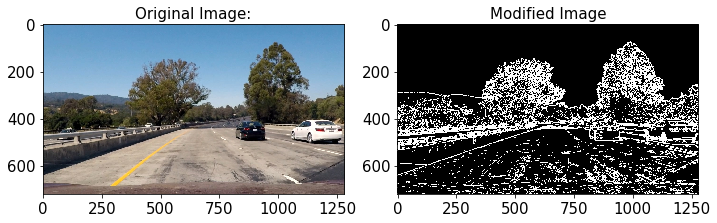

In [210]:
def grad_mag(img, sobel_kernel=3, mag_thresh=(15, 255)):
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
            sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

            sobelMag = np.sqrt(sobelx ** 2 + sobely ** 2)
            scale_factor = np.max(sobelMag) / 255
            scaledSobel = (sobelMag / scale_factor).astype(np.uint8)

            maskedSobel = np.zeros_like(scaledSobel)
            maskedSobel[(scaledSobel >= mag_thresh[0]) & (scaledSobel <= mag_thresh[1]) ] = 1

            binary_output = np.copy(maskedSobel)
            plt.savefig('../output_images/sobel_gradient.png', bbox_inches="tight")
            #plotResults(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), binary_output)
    
img = cv2.imread('../test_images/test1.jpg')
mag_thresh(images)

#### Sobel Direction

In [211]:
def sobel_dir(image, sobel_kernel=9, thresh=(0.7, 1.1)):
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        abs_sobelx = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
        abs_sobely = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))

        #Calculating Direction of Gradient
        dir_gradient = np.arctan2(abs_sobely, abs_sobelx)

        #scale = max(dir_gradient)/255
        #scaled_dir_grad = dir_gradient/scale

        masked_dir_grad = np.zeros_like(dir_gradient)
        masked_dir_grad[(dir_gradient >= thresh[0]) & (dir_gradient <= thresh[1])] = 1

        binary_output = np.copy(masked_dir_grad)

        plt.savefig('../output_images/sobel_direction.png', bbox_inches="tight")
        #plotResults(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), binary_output)
    
img = cv2.imread('../test_images/test1.jpg')
sobel_dir(img)

<Figure size 432x288 with 0 Axes>

#### Color Thresholding

<Figure size 432x288 with 0 Axes>

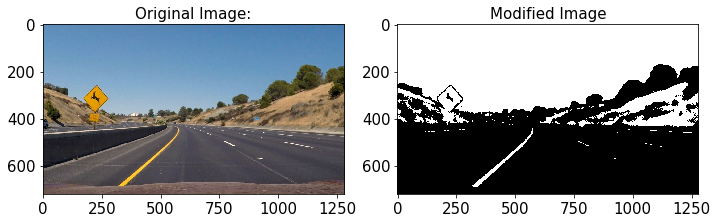

In [214]:
def color_threshold(img, HLS_s_threshold=(60, 255), HSV_v_threshold=(120,255)):
        hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
        s_channel = hls[:,:,2]
        s_binary = np.zeros_like(s_channel)
        s_binary[(s_channel > HLS_s_threshold[0]) & (s_channel <= HLS_s_threshold[1])] = 1
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        v_channel = hsv[:,:,2]
        v_binary = np.zeros_like(v_channel)
        v_binary[(v_channel > HSV_v_threshold[0]) & (v_channel <= HSV_v_threshold[1])] = 1  
        binary_output = np.zeros_like(s_channel)
        binary_output[(s_binary == 1) & (v_binary == 1)] = 1
        plt.savefig('../output_images/color_threshold.png', bbox_inches="tight")
        plotResults(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), binary_output)
    
img = cv2.imread('../test_images/test2.jpg')
color_threshold(img)
    
    

### Reconciled Thresholds

<Figure size 432x288 with 0 Axes>

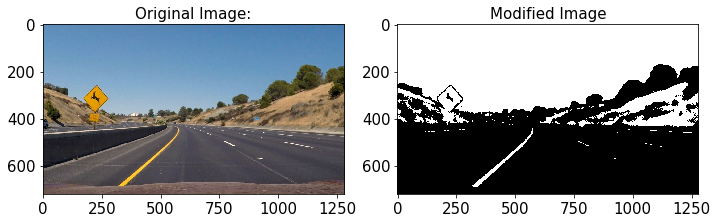

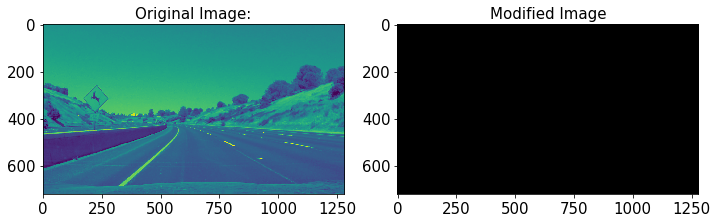

In [220]:
def reconciled_thresholds(img):
        binary_x = sobel_x(img)
        binary_y = sobel_y(img)
        mag = grad_mag(img)
        direction = sobel_dir(img)
        color = color_threshold(img)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        binary_output = np.zeros_like(img)
        binary_output[(binary_x == 1) & (binary_y == 1) & (mag == 1) | (color == 1) | (mag == 1) & (direction == 1)] = 1
        plt.savefig('../output_images/reconciled_thresholds.png', bbox_inches="tight")
        plotResults(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), binary_output)
    
img = cv2.imread('../test_images/test2.jpg')
reconciled_thresholds(img)
    

